# Tugas 5 : meringkas satu berita

## 1. Import Library

In [1]:
import requests
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

- requests: Digunakan untuk mengirim permintaan HTTP untuk mengambil konten dari URL.
- BeautifulSoup: Digunakan untuk mem-parsing HTML dan mengekstrak informasi dari dokumen HTML.
- nltk.tokenize: Digunakan untuk memecah teks menjadi kalimat.
- TfidfVectorizer: Mengubah teks menjadi representasi numerik menggunakan metode TF-IDF (Term Frequency-Inverse Document Frequency).
- cosine_similarity: Menghitung kesamaan antara dua vektor menggunakan rumus kesamaan kosinus.
- networkx: Digunakan untuk membuat dan memanipulasi graf.
- matplotlib.pyplot: Digunakan untuk membuat visualisasi graf.
pandas: Digunakan untuk manipulasi dan analisis data dalam bentuk tabel.
- numpy: Digunakan untuk operasi numerik dan manipulasi array.

## 2. Mengambil Konten Berita

In [2]:
# URL dari mana artikel berita diambil
url = 'https://nasional.tempo.co/read/1926258/momen-jokowi-prabowo-makan-malam-bersama-jelang-pelantikan-20-oktober'

# Mengirim permintaan HTTP ke halaman
response = requests.get(url)

# Membuat objek BeautifulSoup untuk mem-parsing HTML
soup = BeautifulSoup(response.content, 'html.parser')

# Mengambil konten berita dari elemen <p> dalam div dengan class "detail-konten"
news_content = soup.find('div', class_='detail-konten').find_all('p')

# Menggabungkan teks dari semua elemen <p> menjadi satu string
article_text = ' '.join([p.get_text() for p in news_content])


## 3. Preprocessing - Tokenisasi Teks

In [3]:
# Langkah 2: Preprocessing - Tokenisasi teks menjadi kalimat
sentences = sent_tokenize(article_text)


- sent_tokenize(article_text): Memecah teks artikel menjadi kalimat menggunakan fungsi sent_tokenize dari NLTK.

## 4. Vektorisasi TF-IDF

In [4]:
# Langkah 3: Vektorisasi TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(sentences)

- TfidfVectorizer(): Membuat objek TfidfVectorizer.
- fit_transform(sentences): Mengubah kalimat menjadi matriks TF-IDF.

## 5. Menghitung Kesamaan Kosinus

In [5]:
# Langkah 4: Menghitung kesamaan kosinus antara kalimat
cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)


- cosine_similarity(tfidf_matrix, tfidf_matrix): Menghitung kesamaan kosinus antara semua pasangan kalimat.

## 6. Mengubah Matriks Kesamaan ke Biner

In [6]:
# Mengubah matriks kesamaan menjadi 0 dan 1 berdasarkan ambang batas 0,5
binary_cosine_sim_matrix = np.where(cosine_sim_matrix >= 0.05, 1, 0)


## 7. Menampilkan Matriks Kesamaan

In [7]:
# Menampilkan matriks kesamaan kosinus dalam bentuk tabel
cosine_sim_df = pd.DataFrame(cosine_sim_matrix,
                              index=[f'Kalimat {i+1}' for i in range(len(sentences))],
                              columns=[f'Kalimat {i+1}' for i in range(len(sentences))])

# Menampilkan matriks kesamaan biner dalam bentuk tabel
binary_cosine_sim_df = pd.DataFrame(binary_cosine_sim_matrix,
                                     index=[f'Kalimat {i+1}' for i in range(len(sentences))],
                                     columns=[f'Kalimat {i+1}' for i in range(len(sentences))])


- pd.DataFrame(...): Membuat DataFrame Pandas dari matriks kesamaan kosinus dan kesamaan biner, dengan label untuk baris dan kolom berdasarkan nomor kalimat.

## 8. Menampilkan Tabel di Jupyter Notebook

In [8]:
# Jika Anda ingin melihat tabel di Jupyter Notebook, gunakan display()
try:
    from IPython.display import display
    display(cosine_sim_df.style.background_gradient(cmap='viridis').format("{:.2f}"))  # Format dua desimal
    display(binary_cosine_sim_df.style.background_gradient(cmap='viridis'))  # Format dua desimal
except ImportError:
    print("Matriks Kesamaan Kosinus:")
    print(cosine_sim_df.round(2))  # Format dua desimal
    print("\nMatriks Kesamaan (Biner):")
    print(binary_cosine_sim_df)

,Kalimat 1,Kalimat 2,Kalimat 3,Kalimat 4,Kalimat 5,Kalimat 6,Kalimat 7,Kalimat 8,Kalimat 9,Kalimat 10,Kalimat 11,Kalimat 12,Kalimat 13,Kalimat 14,Kalimat 15,Kalimat 16,Kalimat 17,Kalimat 18,Kalimat 19,Kalimat 20
Kalimat 1,1.00,0.00,0.03,0.00,0.17,0.13,0.07,0.11,0.16,0.06,0.15,0.04,0.03,0.02,0.03,0.00,0.03,0.00,0.09,0.03
Kalimat 2,0.00,1.00,0.05,0.06,0.00,0.11,0.03,0.00,0.00,0.07,0.03,0.05,0.00,0.00,0.00,0.04,0.09,0.00,0.08,0.06
Kalimat 3,0.03,0.05,1.00,0.13,0.05,0.07,0.06,0.04,0.04,0.21,0.02,0.02,0.04,0.07,0.01,0.03,0.05,0.00,0.03,0.13
Kalimat 4,0.00,0.06,0.13,1.00,0.04,0.03,0.00,0.05,0.00,0.00,0.00,0.00,0.00,0.06,0.06,0.00,0.00,0.00,0.00,0.17
Kalimat 5,0.17,0.00,0.05,0.04,1.00,0.02,0.16,0.18,0.12,0.03,0.02,0.09,0.01,0.04,0.06,0.00,0.01,0.01,0.10,0.01
Kalimat 6,0.13,0.11,0.07,0.03,0.02,1.00,0.12,0.08,0.11,0.01,0.15,0.04,0.14,0.05,0.03,0.05,0.08,0.00,0.08,0.09
Kalimat 7,0.07,0.03,0.06,0.00,0.16,0.12,1.00,0.09,0.09,0.03,0.04,0.06,0.23,0.13,0.00,0.05,0.04,0.05,0.34,0.22
Kalimat 8,0.11,0.00,0.04,0.05,0.18,0.08,0.09,1.00,0.04,0.03,0.00,0.07,0.13,0.20,0.03,0.00,0.01,0.01,0.05,0.01
Kalimat 9,0.16,0.00,0.04,0.00,0.12,0.11,0.09,0.04,1.00,0.08,0.14,0.07,0.05,0.04,0.02,0.00,0.06,0.02,0.10,0.05
Kalimat 10,0.06,0.07,0.21,0.00,0.03,0.01,0.03,0.03,0.08,1.00,0.04,0.00,0.06,0.02,0.00,0.00,0.03,0.00,0.08,0.03


,Kalimat 1,Kalimat 2,Kalimat 3,Kalimat 4,Kalimat 5,Kalimat 6,Kalimat 7,Kalimat 8,Kalimat 9,Kalimat 10,Kalimat 11,Kalimat 12,Kalimat 13,Kalimat 14,Kalimat 15,Kalimat 16,Kalimat 17,Kalimat 18,Kalimat 19,Kalimat 20
Kalimat 1,1,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0
Kalimat 2,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,1
Kalimat 3,0,0,1,1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,1
Kalimat 4,0,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1
Kalimat 5,1,0,0,0,1,0,1,1,1,0,0,1,0,0,1,0,0,0,1,0
Kalimat 6,1,1,1,0,0,1,1,1,1,0,1,0,1,1,0,0,1,0,1,1
Kalimat 7,1,0,1,0,1,1,1,1,1,0,0,1,1,1,0,1,0,1,1,1
Kalimat 8,1,0,0,0,1,1,1,1,0,0,0,1,1,1,0,0,0,0,1,0
Kalimat 9,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,0,1,0,1,1
Kalimat 10,1,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0


- display(): Digunakan untuk menampilkan DataFrame dalam Jupyter Notebook dengan format yang lebih baik (gradien warna).
- print(): Jika tidak dalam lingkungan Jupyter, akan mencetak matriks kesamaan kosinus dan biner ke konsol.

## 9. Membangun Graf Kesamaan Kalimat

In [9]:
# Langkah 5: Membangun graf di mana node adalah kalimat, dan tepi adalah kesamaan kosinus
graph = nx.Graph()

# Menambahkan node (kalimat) ke dalam graf
for i, sentence in enumerate(sentences):
    graph.add_node(i, label=sentence)  # Menyimpan kalimat sebagai label

# Menambahkan tepi dengan bobot berdasarkan kesamaan biner
for i in range(len(sentences)):
    for j in range(i + 1, len(sentences)):
        if binary_cosine_sim_matrix[i, j] == 1:  # Hanya menambahkan tepi untuk kesamaan yang 1
            graph.add_edge(i, j)  # Bobot tidak perlu lagi, karena kita menggunakan biner


- nx.Graph(): Membuat objek graf kosong menggunakan NetworkX.
- graph.add_node(...): Menambahkan node ke dalam graf untuk setiap kalimat.
- graph.add_edge(...): Menambahkan tepi di antara kalimat yang memiliki kesamaan biner (1).

## 10. Memeriksa Tepi dan Visualisasi Graf

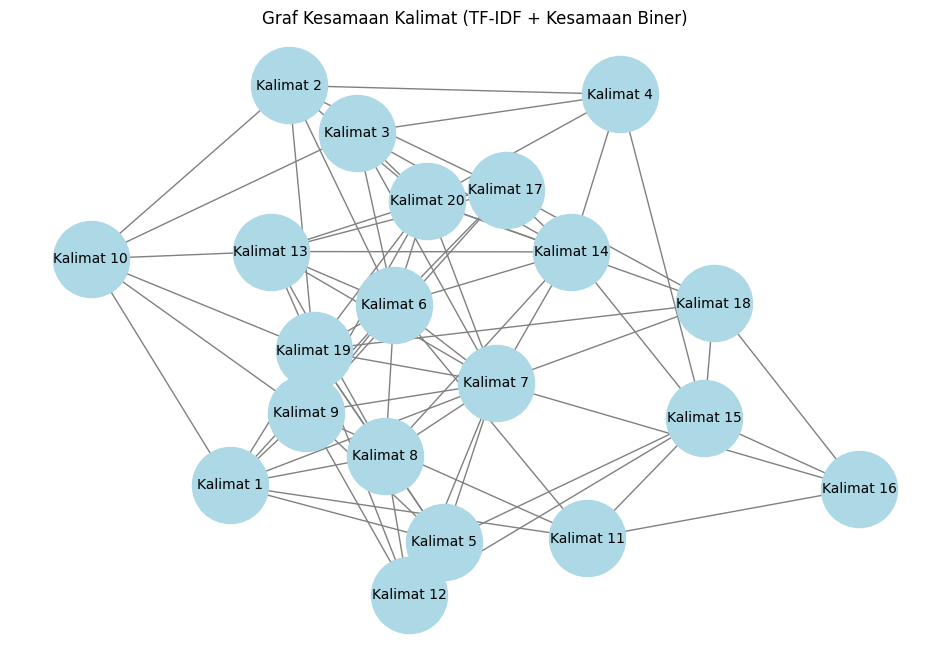

In [10]:
# Memeriksa apakah ada tepi
if len(graph.edges()) == 0:
    print("Tidak ada tepi yang dibuat. Periksa ambang batas kesamaan atau data input.")
else:
# Langkah 6: Visualisasikan graf menggunakan NetworkX
      plt.figure(figsize=(12, 8))
      pos = nx.spring_layout(graph, k=0.5)  # Layout untuk visualisasi yang lebih baik

      # Menggambar node
      nx.draw_networkx_nodes(graph, pos, node_color='lightblue', node_size=3000)

      # Menggambar tepi
      nx.draw_networkx_edges(graph, pos, edge_color='gray')

      # Menggambar label hanya dengan nomor kalimat
      labels = {i: f'Kalimat {i+1}' for i in graph.nodes()}  # Hanya menampilkan nomor kalimat
      nx.draw_networkx_labels(graph, pos, labels, font_size=10)

      plt.title("Graf Kesamaan Kalimat (TF-IDF + Kesamaan Biner)")
      plt.axis('off')  # Menyembunyikan sumbu untuk presentasi yang lebih baik
      plt.show()


- len(graph.edges()): Memeriksa jumlah tepi yang ada dalam graf.
- plt.figure(...): Membuat sebuah figure baru untuk visualisasi graf.
- nx.spring_layout(...): Mengatur posisi node dalam graf untuk visualisasi.
- nx.draw_networkx_nodes(...): Menggambar node dalam graf.
- nx.draw_networkx_edges(...): Menggambar tepi dalam graf.
- nx.draw_networkx_labels(...): Menggambar label untuk setiap node, hanya menampilkan nomor kalimat.
- plt.title(...) dan plt.axis('off'): Menambahkan judul dan menyembunyikan sumbu untuk tampilan yang lebih baik.
- plt.show(): Menampilkan graf yang telah digambar.